# Split and Merge for image segmentation

In [1]:
import numpy as np
import networkx as nx
import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from skimage import img_as_float

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap='gray')
        ax.set_title(label)

def print_images(images, nrows=1, ncols=1, titles=None):
    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap='gray')
        ax.set_title(label)


def split_and_merge(img, min_size, variance_threshold, intensity_threshold):
    height, width = img.shape[:2]
    labels = np.zeros((height, width), dtype=np.int32)
    label = 1
    
    def split(x1, y1, x2, y2):
        nonlocal label
        if x2 - x1 <= min_size or y2 - y1 <= min_size:
            return
        block = img[y1:y2, x1:x2]
        mean, std = cv2.meanStdDev(block)
        if std > variance_threshold:
            xm = (x1 + x2) // 2
            ym = (y1 + y2) // 2
            split(x1, y1, xm, ym)
            split(xm, y1, x2, ym)
            split(x1, ym, xm, y2)
            split(xm, ym, x2, y2)
        else:
            labels[y1:y2, x1:x2] = label
            label += 1
    
    split(0, 0, width, height)
    rag = create_rag(None, labels)
    for (label1, label2) in list(rag.edges()):
        block1 = img[labels == label1]
        block2 = img[labels == label2]
        if block1.shape[0] == 0 or block2.shape[0] == 0:
            continue
        mean1, std1 = cv2.meanStdDev(block1)
        mean2, std2 = cv2.meanStdDev(block2)
        if abs(mean1 - mean2) < intensity_threshold:
            rag.remove_edge(label1, label2)
            new_label = min(label1, label2)
            labels[labels == label1] = new_label
            labels[labels == label2] = new_label
            rag.nodes[label1]['merged'] = True
            rag.nodes[label2]['merged'] = True
            
    seg_img = np.zeros((height, width), dtype=np.uint8)
    for i in np.unique(labels):
        mean = np.mean(img[labels == i])
        seg_img[labels == i] = mean
    
    #UNCOMMENT BELOW FOR RANDOM COLORS
    
    #colors = np.random.randint(0, 256, size=label, dtype=np.uint8)
    #seg_img = colors[labels]
    
    return seg_img

def create_rag(graph, labels):
    height, width = labels.shape
    if graph is None:
        graph = nx.Graph()
    label_ids = np.unique(labels)
    for label in label_ids:
        graph.add_node(label, merged=False)
    for y in range(height):
        for x in range(width):
            current_label = labels[y, x]
            neighbors = []
            if x > 0:
                left_label = labels[y, x - 1]
                if current_label != left_label:
                    neighbors.append(left_label)
            if x < width - 1:
                right_label = labels[y, x + 1]
                if current_label != right_label:
                    neighbors.append(right_label)
            if y > 0:
                up_label = labels[y - 1, x]
                if current_label != up_label:
                    neighbors.append(up_label)
            if y < height - 1:
                down_label = labels[y + 1, x]
                if current_label != down_label:
                    neighbors.append(down_label)
            for neighbor in neighbors:
                if not graph.has_edge(current_label, neighbor):
                    graph.add_edge(current_label, neighbor)
    return graph

# Split and Merge: Apples

## Load the image

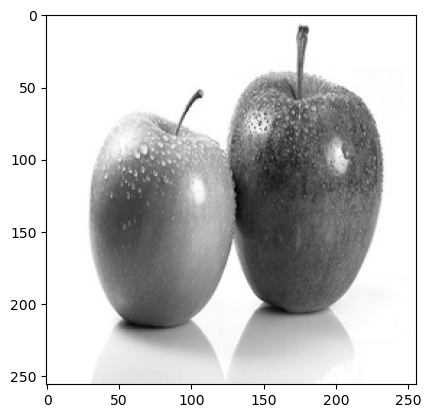

In [2]:
image = cv2.imread('apple.jpg') #loading apples image

#convert the image from BGR to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.show()

### the 'split_and_merge' function will segment an image based on two phases:
### During the split phase the image is recursively decomposed in blocks of decreasing dimension until the standard deviation of each block is low enough of if the minimum block size has been reached. 
### During the merge phase, pairs of adjacent blocks are merged together if the difference of intensity between them is low enough. to keep track of adjacent blocks a Region Adjacency Graph (RAG) structure has been used.

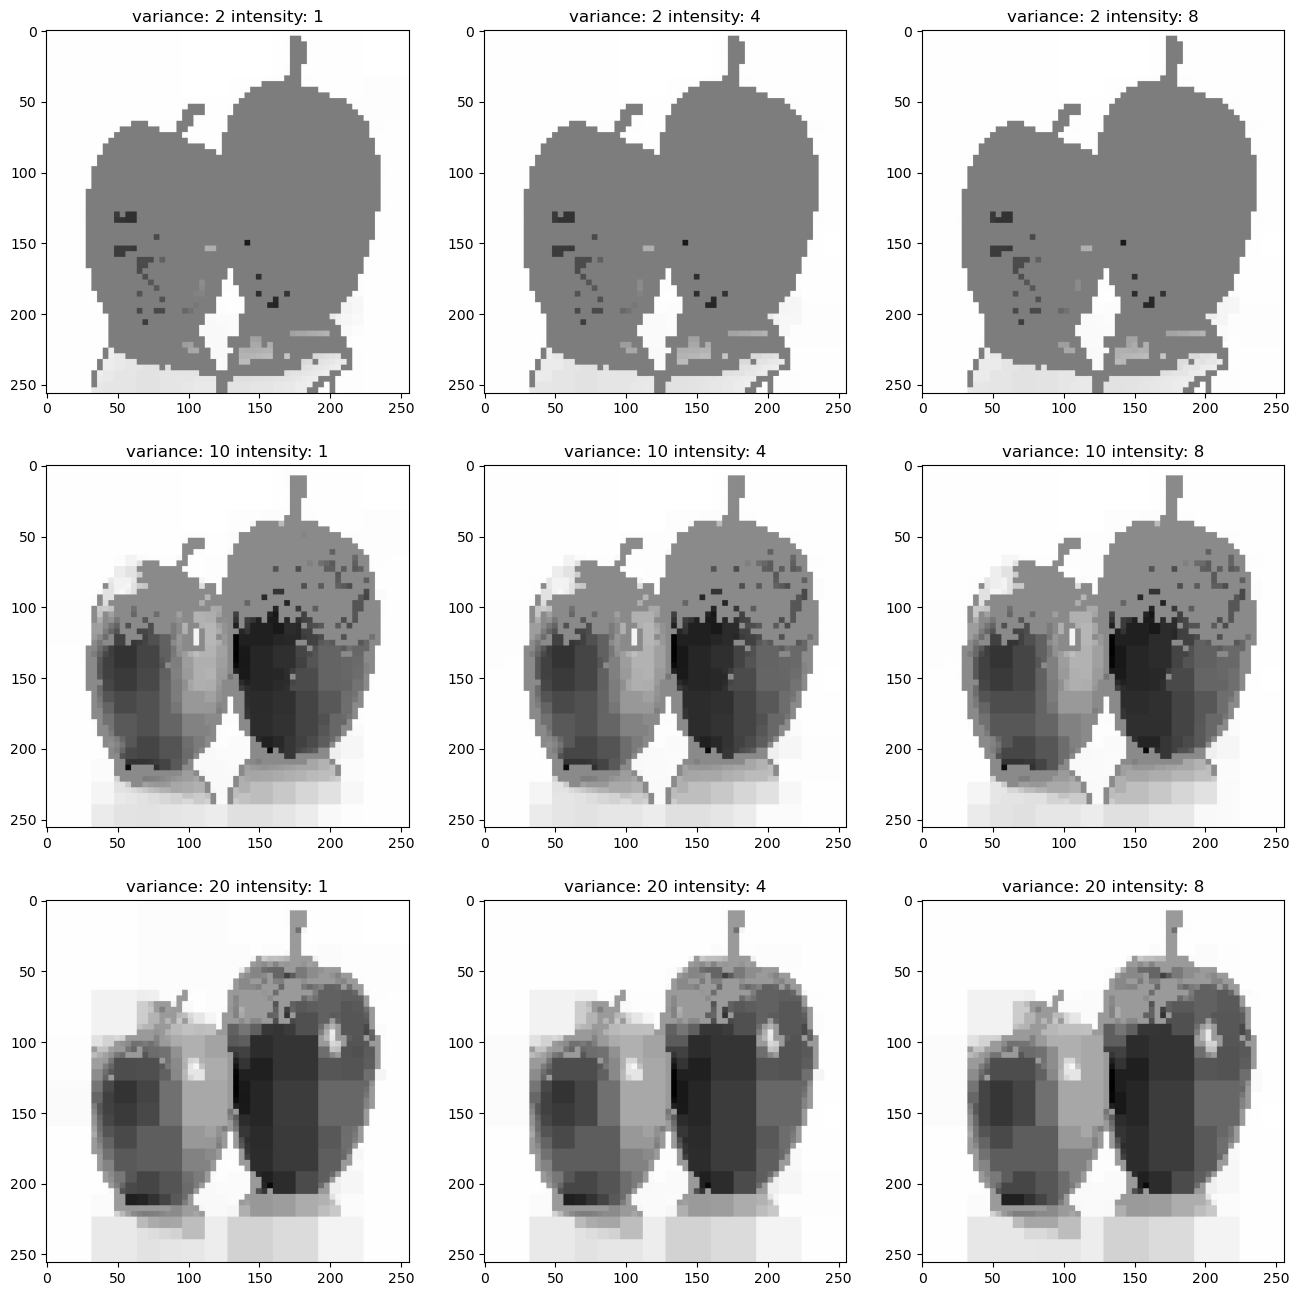

In [3]:
block_size = 2
variance_thresholds = [2, 10, 20]
intensity_thresholds = [1, 4, 8]
segmented_images = []
captions = []
for variance in variance_thresholds:
    for intensity in intensity_thresholds:
        segmented_images.append(split_and_merge(gray_image, block_size, variance, intensity))
        captions.append('variance: ' + str(variance) + ' intensity: ' + str(intensity))

print_images(segmented_images, len(variance_thresholds), len(intensity_thresholds), captions)

# Split and Merge: Peppers

## Load the image

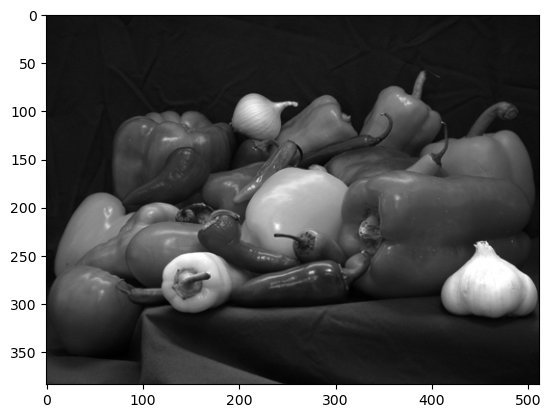

In [4]:
image = cv2.imread('peppers.jpg') #loading apples image

#convert the image from BGR to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')
plt.show()

## Apply the split and merge algorithm

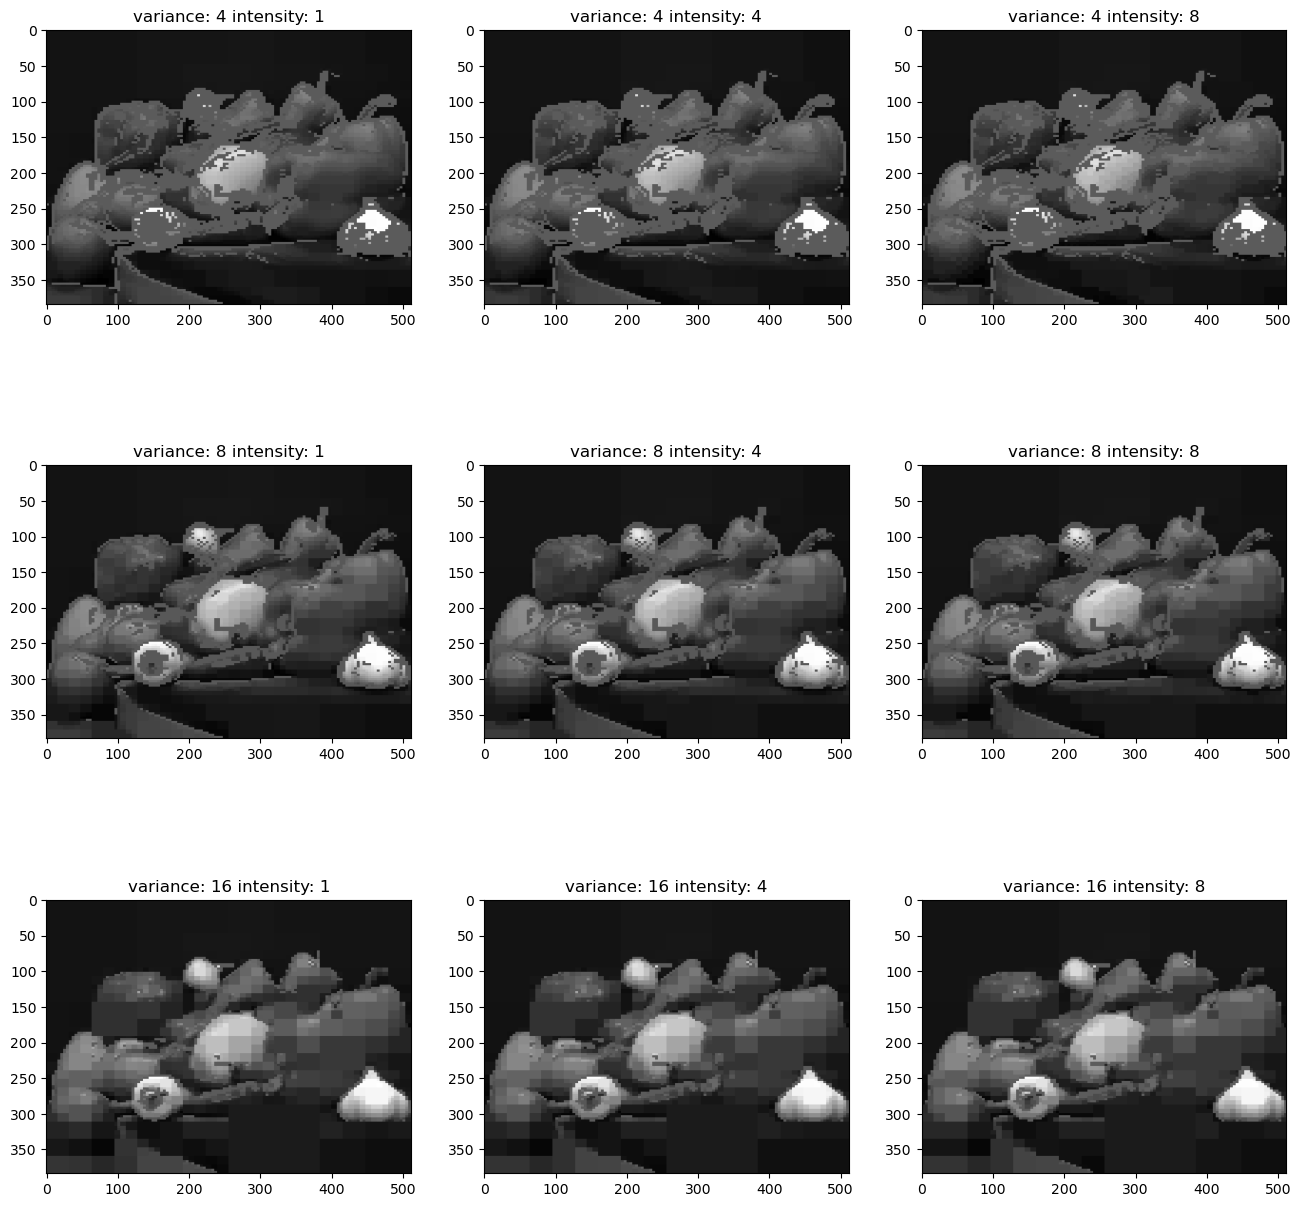

In [5]:
block_size = 2
variance_thresholds = [4, 8, 16]
intensity_thresholds = [1, 4, 8]
segmented_images = []
captions = []
for variance in variance_thresholds:
    for intensity in intensity_thresholds:
        segmented_images.append(split_and_merge(gray_image, block_size, variance, intensity))
        captions.append('variance: ' + str(variance) + ' intensity: ' + str(intensity))

print_images(segmented_images, len(variance_thresholds), len(intensity_thresholds), captions)